In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
train = pd.read_csv('../datasets/gpt_data/definitive/train.csv')

In [8]:
train['label'] = train['label'].astype(int)

In [9]:
train = train[['plot', 'label']]
train

,plot,label
0,the doll is a 1919 silent film directed by e...,1
1,the way down east is a 1920 silent film dire...,1
2,destiny is a 1921 german silent fantasy film...,1
3,the navigator is a 1924 silent comedy film s...,1
4,the phantom of the opera is a 1925 silent ho...,1
...,...,...
7954,the trauma center is a 2019 drama film direc...,0
7955,slaxx is a 2020 horror-comedy about a posses...,0
7956,the kindred is a 2020 science fiction horror...,0
7957,the bee gees: how can you mend a broken hear...,1


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7959 entries, 0 to 7958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   plot    7959 non-null   object
 1   label   7959 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.5+ KB


min length: 366 
max length: 776


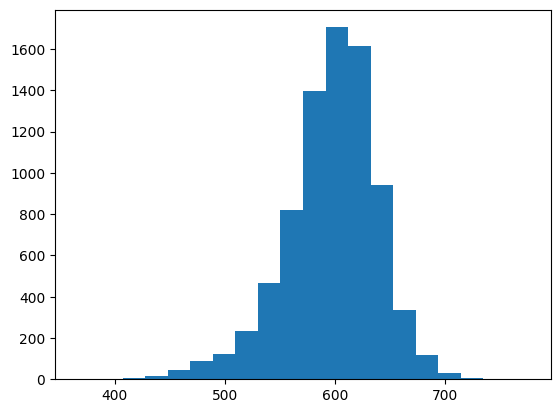

In [11]:
lengths = []
for i, sentence in enumerate(train['plot']):
    lengths.append(len(sentence))
    
plt.hist(lengths, bins=20);  
print('min length:', min(lengths),'\nmax length:',max(lengths))  

In [7]:
#NEW TRAIN TEST SPLIT (this randomization is the same for this notebook and the lightgbm notebook)
train = train.sample(frac=1, random_state=420).reset_index(drop=True)
train.head()

,plot,label
0,"in 1968, a small town in the midwest is rock...",0
1,hawaizaada is a 2015 indian biographical dra...,0
2,the beverly hillbillies is a 1993 comedy fil...,0
3,the man who came to dinner is a 1942 comedy ...,1
4,the black godfather is a biographical drama ...,1


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [9]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Example movie plot
plot = list(train['plot'].values)[0]
plot = "A young woman falls in love with a man who is secretly a prince."

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the plot using the tokenizer's encode() method
tokens = tokenizer.encode(plot, add_special_tokens=True)

# The tokens variable now contains the token IDs of the tokenized plot
print('Original plot:', plot)
print()
print('Tokenized plot:', tokenizer.convert_ids_to_tokens(tokens))
print()
print('Token IDs:', tokens)

Original plot: A young woman falls in love with a man who is secretly a prince.

Tokenized plot: ['[CLS]', 'a', 'young', 'woman', 'falls', 'in', 'love', 'with', 'a', 'man', 'who', 'is', 'secretly', 'a', 'prince', '.', '[SEP]']

Token IDs: [101, 1037, 2402, 2450, 4212, 1999, 2293, 2007, 1037, 2158, 2040, 2003, 10082, 1037, 3159, 1012, 102]


In [11]:
max_len = 128 # maximum sequence length to use

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#encoded_plots = tokenizer.batch_encode_plus(list(train['plot'].values), add_special_tokens=True, max_length=max_len, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_tensors='pt')
encoded_plots = tokenizer.batch_encode_plus(list(train['plot'].values), add_special_tokens=True, max_length=max_len, 
                                            padding=True, truncation=True, return_tensors='pt')

In [12]:
encoded_plots['input_ids'].shape

torch.Size([7959, 128])

In [13]:
labels_tensor = torch.tensor(train['label'])

### Old Shuffle

In [14]:
# Create a TensorDataset and DataLoader for training and validation
dataset = TensorDataset(encoded_plots['input_ids'], encoded_plots['attention_mask'], labels_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


### New shuffle (same to lightGBM)

In [44]:
train_size = int(0.8 * len(train))

train_dataset = TensorDataset(
    encoded_plots['input_ids'][:train_size], 
    encoded_plots['attention_mask'][:train_size], 
    labels_tensor[:train_size]
)

val_dataset = TensorDataset(
    encoded_plots['input_ids'][train_size:], 
    encoded_plots['attention_mask'][train_size:], 
    labels_tensor[train_size:]
)
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #cambiaaa
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [45]:
#test
train['label'][0:15]

0     0
1     0
2     0
3     1
4     1
5     1
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
14    1
Name: label, dtype: int64

In [46]:
#test
for i, batch in enumerate(train_dataloader):
    print(batch[2])
    break

tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0])


## Model

In [15]:
# Load the pre-trained BERT model and add a classification layer on top of it
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune the BERT model
model.to(device)
model.train()

for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad() #set the gradients to zero for each batch
        
        # forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #still don't know what it does
        
        #parameter update based on the current gradient (stored in . grad attribute of a parameter)
        optimizer.step()
        
        #update learning rate with scheduler
        scheduler.step()
        
        if i % 50 == 0:
            print(f'epoch:{epoch}, batch {i} out of {len(train_dataset)//batch_size} is done')

    # Evaluate the model on the validation set after each epoch
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            val_accuracy += torch.sum(preds == labels).item()

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataset)

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


epoch:0, batch 0 out of 248 is done
epoch:0, batch 50 out of 248 is done
epoch:0, batch 100 out of 248 is done
epoch:0, batch 150 out of 248 is done
epoch:0, batch 200 out of 248 is done
Epoch 1/3, Validation Loss: 0.4804, Validation Accuracy: 0.7741
epoch:1, batch 0 out of 248 is done
epoch:1, batch 50 out of 248 is done
epoch:1, batch 100 out of 248 is done
epoch:1, batch 150 out of 248 is done
epoch:1, batch 200 out of 248 is done
Epoch 2/3, Validation Loss: 0.4570, Validation Accuracy: 0.7942
epoch:2, batch 0 out of 248 is done
epoch:2, batch 50 out of 248 is done
epoch:2, batch 100 out of 248 is done
epoch:2, batch 150 out of 248 is done
epoch:2, batch 200 out of 248 is done
Epoch 3/3, Validation Loss: 0.5175, Validation Accuracy: 0.7940


### Model on ALL dataset

In [15]:
# ADDDDD
batch_size = 16

dataset = TensorDataset(encoded_plots['input_ids'], encoded_plots['attention_mask'], labels_tensor)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #cambiaaa

In [43]:
#check
0.8*len(dataset)//batch_size

397.0

In [22]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune the BERT model
model.to(device)
model.train()

for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad() #set the gradients to zero for each batch
        
        # forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #still don't know what it does
        
        #parameter update based on the current gradient (stored in . grad attribute of a parameter)
        optimizer.step()
        
        #update learning rate with scheduler
        scheduler.step()
        
        if i % 50 == 0:
            print(f'epoch:{epoch}, batch {i} out of {len(dataset)//batch_size} is done')

    

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


epoch:0, batch 0 out of 497 is done
epoch:0, batch 50 out of 497 is done
epoch:0, batch 100 out of 497 is done
epoch:0, batch 150 out of 497 is done
epoch:0, batch 200 out of 497 is done
epoch:0, batch 250 out of 497 is done
epoch:0, batch 300 out of 497 is done
epoch:0, batch 350 out of 497 is done
epoch:0, batch 400 out of 497 is done
epoch:0, batch 450 out of 497 is done
epoch:1, batch 0 out of 497 is done
epoch:1, batch 50 out of 497 is done
epoch:1, batch 100 out of 497 is done
epoch:1, batch 150 out of 497 is done
epoch:1, batch 200 out of 497 is done
epoch:1, batch 250 out of 497 is done
epoch:1, batch 300 out of 497 is done
epoch:1, batch 350 out of 497 is done
epoch:1, batch 400 out of 497 is done
epoch:1, batch 450 out of 497 is done
epoch:2, batch 0 out of 497 is done
epoch:2, batch 50 out of 497 is done
epoch:2, batch 100 out of 497 is done
epoch:2, batch 150 out of 497 is done
epoch:2, batch 200 out of 497 is done
epoch:2, batch 250 out of 497 is done
epoch:2, batch 300 ou

### Save the model

In [17]:
torch.save(model.state_dict(), 'model_new_plts.pth')

### Load model

In [64]:
# Define your model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load saved model weights
model.load_state_dict(torch.load('model_new_plts.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

## Submission

In [12]:
validation = pd.read_csv('../datasets/gpt_data/definitive/validation.csv')[['tconst','plot']]
test = pd.read_csv('../datasets/gpt_data/definitive/test.csv')[['tconst','plot']]

In [13]:
validation.shape, test.shape

((955, 2), (1086, 2))

In [87]:
#check if null values
null_mask = validation['plot'].isnull()
rows_with_nulls = validation['plot'][null_mask]
rows_with_nulls

Series([], Name: plot, dtype: object)

In [21]:
#check if null values
null_mask = test['plot'].isnull()
rows_with_nulls = test['plot'][null_mask]
rows_with_nulls

Series([], Name: plot, dtype: object)

In [22]:
validation = validation['plot']
test = test['plot']

### SUBMIT Validation

In [23]:
encoded_unseen_data = tokenizer.batch_encode_plus(validation, 
                                                  add_special_tokens=True, 
                                                  max_length=max_len, 
                                                  padding=True, 
                                                  truncation=True, 
                                                  return_attention_mask=True, 
                                                  return_tensors='pt')

unseen_dataset = TensorDataset(encoded_unseen_data['input_ids'], encoded_unseen_data['attention_mask'])
unseen_dataloader = DataLoader(unseen_dataset, batch_size=batch_size)

In [24]:
import torch.nn.functional as F

model.eval()
predictions = []
bert_variable = []
with torch.no_grad():
    for batch in unseen_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, batch_predictions = torch.max(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        
        probabilities = F.softmax(logits, dim=1)[:,1] #bertvariable
        bert_variable.extend(probabilities.tolist())

In [25]:
predictions[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
bert_variable[0:10]

[0.9623507857322693,
 0.9796537756919861,
 0.9834833145141602,
 0.9761279225349426,
 0.8242197632789612,
 0.9791146516799927,
 0.9665980935096741,
 0.9766606688499451,
 0.9743089079856873,
 0.9702649712562561]

In [27]:
pd.DataFrame(predictions)[0].map({1:"True", 0:"False"}).to_csv("../datasets/bert_outputs/bert_predictions_validation.csv",
                                                                    index=False, header=False)

In [28]:
pd.DataFrame(bert_variable)[0].to_csv("../datasets/bert_outputs/bert_variable_validation.csv", index=False, header=False)

### SUBMIT Test

In [29]:
encoded_unseen_data = tokenizer.batch_encode_plus(test, 
                                                  add_special_tokens=True, 
                                                  max_length=max_len, 
                                                  padding=True, 
                                                  truncation=True, 
                                                  return_attention_mask=True, 
                                                  return_tensors='pt')

unseen_dataset = TensorDataset(encoded_unseen_data['input_ids'], encoded_unseen_data['attention_mask'])
unseen_dataloader = DataLoader(unseen_dataset, batch_size=batch_size)

In [30]:
import torch.nn.functional as F

model.eval()
predictions = []
bert_variable = []
with torch.no_grad():
    for batch in unseen_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, batch_predictions = torch.max(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        
        probabilities = F.softmax(logits, dim=1)[:,1] #bertvariable
        bert_variable.extend(probabilities.tolist())

In [31]:
pd.DataFrame(predictions)[0].map({1:"True", 0:"False"}).to_csv("../datasets/bert_outputs/bert_predictions_test.csv",
                                                                    index=False, header=False)

In [32]:
pd.DataFrame(bert_variable)[0].to_csv("../datasets/bert_outputs/bert_variable_test.csv", index=False, header=False)

### SUBMIT Train

In [33]:
dataset = TensorDataset(encoded_plots['input_ids'], encoded_plots['attention_mask'], labels_tensor)

full_dataset_dataloader = DataLoader(dataset, batch_size=batch_size)

In [34]:
import torch.nn.functional as F

model.eval()
predictions = []
bert_variable = []
with torch.no_grad():
    for batch in full_dataset_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, batch_predictions = torch.max(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        
        probabilities = F.softmax(logits, dim=1)[:,1] #bertvariable
        bert_variable.extend(probabilities.tolist())

In [35]:
pd.DataFrame(predictions)[0].map({1:"True", 0:"False"}).to_csv("../datasets/bert_outputs/bert_predictions_train.csv",
                                                                    index=False, header=False)

In [36]:
pd.DataFrame(bert_variable)[0].to_csv("../datasets/bert_outputs/bert_variable_train.csvv", index=False, header=False)